In [1]:

import os
os.chdir("D:/Pinelopi/Documents/Σημαντικά/Data Scientist/Project/Original Data/EEA")
os.getcwd()

#Import important libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import f_oneway
import numpy as np


from sklearn.model_selection  import train_test_split
from sklearn.linear_model     import LinearRegression
from sklearn.metrics          import mean_squared_error
from sklearn.metrics          import mean_absolute_error
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import neighbors



In [2]:
# Read csv file and display basic information
df19= pd.read_csv("df_random_final.csv")
df19.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154997 entries, 0 to 154996
Data columns (total 39 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            154997 non-null  int64  
 1   ID                    154997 non-null  int64  
 2   Country               154997 non-null  object 
 3   VFN                   76845 non-null   object 
 4   Mp                    146363 non-null  object 
 5   Mh                    154997 non-null  object 
 6   Man                   154997 non-null  object 
 7   MMS                   150910 non-null  object 
 8   Tan                   154791 non-null  object 
 9   T                     154857 non-null  object 
 10  Va                    154785 non-null  object 
 11  Ve                    154780 non-null  object 
 12  Mk                    154986 non-null  object 
 13  Cn                    154939 non-null  object 
 14  Ct                    154712 non-null  object 
 15  

In [3]:

# DROP Mt , because it relates to WLTP standard, whereas m (kg) relates to NDCD standard. Renaming m (kg) into "Mass".
df = df19.drop(["Unnamed: 0", "VFN", "Mp","Man","MMS", "Tan", "T", "Va", "Ve", "Mk", "Cn", "Ct", "r",
              "Mt", "Ewltp (g/km)", "At2 (mm)", "De", "Vf", "Status", "Electric range (km)", "Date of registration", "Fuel consumption "], axis=1)

df = df.rename({"Mh": "Manufacturer", "m (kg)": "Mass", "Cr": "Vehicle_Category", "W (mm)": "Wheel_Base", "At1 (mm)": "Axle_Width", "Ft": "Fuel_Type", "Fm": "Fuel_Mode", 
                "ec (cm3)": "Eng_Capacity", "ep (KW)": "Eng_Power", "z (Wh/km)": "Electric_Consum", "Enedc (g/km)": "CO2"}, axis=1)

df = df.set_index("ID")

df = df[["CO2", "Mass", "Axle_Width", "Wheel_Base", "Eng_Capacity", "Eng_Power", "Electric_Consum", "Manufacturer", "Country", "Vehicle_Category", "Fuel_Type", "Fuel_Mode", "IT", "Ernedc (g/km)", "Erwltp (g/km)"]]

df.head()



,CO2,Mass,Axle_Width,Wheel_Base,Eng_Capacity,Eng_Power,Electric_Consum,Manufacturer,Country,Vehicle_Category,Fuel_Type,Fuel_Mode,IT,Ernedc (g/km),Erwltp (g/km)
ID,,,,,,,,,,,,,,,
7701815,102.0,1394.0,1565.0,2730.0,1499.0,96.0,NaN,AUTOMOBILES PEUGEOT,DE,M1,diesel,M,NaN,NaN,NaN
3387186,105.0,1415.0,1573.0,2650.0,1598.0,85.0,NaN,HYUNDAI CZECH,AT,M1,diesel,M,NaN,NaN,NaN
5745360,131.0,1195.0,1535.0,2500.0,1373.0,103.0,NaN,MAGYAR SUZUKI,DE,M1,petrol,M,NaN,NaN,NaN
9394578,85.0,1165.0,1483.0,2539.0,1499.0,75.0,NaN,AUTOMOBILES CITROEN,FR,M1,diesel,M,NaN,NaN,NaN
13508686,56.0,1760.0,1563.0,2670.0,1499.0,100.0,139.0,BMW AG,SE,M1,petrol/electric,P,NaN,NaN,NaN


In [4]:
df.isna().sum()


CO2                    607
Mass                     0
Axle_Width             354
Wheel_Base             160
Eng_Capacity          3498
Eng_Power            22981
Electric_Consum     151864
Manufacturer             0
Country                  0
Vehicle_Category         0
Fuel_Type                0
Fuel_Mode                1
IT                  136079
Ernedc (g/km)       137073
Erwltp (g/km)       154915
dtype: int64

In [5]:
pd.crosstab(df["Fuel_Type"],df["Fuel_Mode"])


Fuel_Mode,B,E,F,H,M,P
Fuel_Type,,,,,,
diesel,0,0,0,682,48856,0
diesel/electric,0,0,0,0,0,135
e85,0,0,70,0,0,0
electric,0,3483,0,0,0,0
hydrogen,0,0,0,4,0,0
lpg,1635,0,0,0,154,0
ng,1,0,0,0,487,0
ng-biomethane,113,0,0,0,84,0
petrol,0,0,0,5543,91892,0


In [6]:
df["Vehicle_Category"] = df["Vehicle_Category"].replace(to_replace = "M1 ", value="M1")

df["Vehicle_Category"] = df["Vehicle_Category"].replace(to_replace = "M1  ", value="M1")

df["Vehicle_Category"] = df["Vehicle_Category"].replace(to_replace = "M1G ", value="M1G")

df["Vehicle_Category"] = df["Vehicle_Category"].replace(to_replace = "m1", value="M1")

df["Vehicle_Category"].value_counts()

Vehicle_Category
M1     150120
M1G      4877
Name: count, dtype: int64

In [7]:
df["Four_Wheel_Drive"] = df["Vehicle_Category"].apply(lambda x: 1 if x=="M1G" else 0)

df["Four_Wheel_Drive"].value_counts()



Four_Wheel_Drive
0    150120
1      4877
Name: count, dtype: int64

In [8]:
# Fuel Types

# remove hydrogen Fuel_Type, because emission is zero
# (although CO2 is produced when the Electricity/Hydrogen is produced)

# remove unknown fuel_type

df["Fuel_Type"].value_counts()


Fuel_Type
petrol             97435
diesel             49538
electric            3483
petrol/electric     1857
lpg                 1789
ng                   488
ng-biomethane        197
diesel/electric      135
e85                   70
hydrogen               4
unknown                1
Name: count, dtype: int64

In [9]:

df = df.drop(df[df["Fuel_Type"] == "hydrogen"].index)
df = df.drop(df[df["Fuel_Type"] == "unknown"].index)

df["Fuel_Type"].value_counts()


Fuel_Type
petrol             97435
diesel             49538
electric            3483
petrol/electric     1857
lpg                 1789
ng                   488
ng-biomethane        197
diesel/electric      135
e85                   70
Name: count, dtype: int64

In [10]:

# Electric consumption is given for Electric, Hybrid as well as for SOME petrol cars (AC etc..)
# CANNOT differentiate into groups using Electric_Consum
# --> use it in the Electic group as an explanatory ?
# is not possible,as shown below, since even here almost half of the observations are NaN
# --> DROPPING variable
df = df.drop(["Electric_Consum"], axis=1)

In [11]:
# Exploring ELECTRIC CARS (E)
# make E only dataframe
df_E = df[df["Fuel_Mode"] == "E"]
df_E.info()
df_E.isna().sum()

# several variables dropped, because too many NaN
df_E = df_E.drop(["Eng_Capacity", "Eng_Power"], axis=1)

# Since observations with missing Axle_Width and Wheel_Base will disturb the regressions, observation with these NaN are dropped
df_E = df_E.dropna(axis=0, how="any", subset=["Axle_Width", "Wheel_Base"])

df_E.isna().sum()
df_E["Manufacturer"].unique()
# Dataframe ready for regressions:
# df_E : Only electric cars, reduced set of variables


<class 'pandas.core.frame.DataFrame'>
Index: 3483 entries, 6084918 to 8304570
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CO2               3483 non-null   float64
 1   Mass              3483 non-null   float64
 2   Axle_Width        3457 non-null   float64
 3   Wheel_Base        3462 non-null   float64
 4   Eng_Capacity      0 non-null      float64
 5   Eng_Power         2873 non-null   float64
 6   Manufacturer      3483 non-null   object 
 7   Country           3483 non-null   object 
 8   Vehicle_Category  3483 non-null   object 
 9   Fuel_Type         3483 non-null   object 
 10  Fuel_Mode         3483 non-null   object 
 11  IT                0 non-null      object 
 12  Ernedc (g/km)     3 non-null      float64
 13  Erwltp (g/km)     0 non-null      float64
 14  Four_Wheel_Drive  3483 non-null   int64  
dtypes: float64(8), int64(1), object(6)
memory usage: 435.4+ KB


array(['DAIMLER AG', 'TESLA', 'RENAULT', 'HYUNDAI', 'NISSAN',
       'JAGUAR LAND ROVER LIMITED', 'SAIC MOTOR', 'VOLKSWAGEN', 'KIA',
       'AUDI AG', 'BMW AG', 'MG MOTOR', 'OPEL AUTOMOBILE',
       'AUTOMOBILES PEUGEOT', 'AA-IVA', 'AUTOMOBILES CITROEN',
       'DUPLICATE', 'ANHUI', 'E-GO', 'PSA', 'SKODA'], dtype=object)

In [12]:
# Fuel Mode

# M, B, F are fossil fuels:
# M (Mono): One fossil fuel
# B (Bi): Two fossil fuels (or Hydrogen; but these car are removed from the data already)
#         kept in two different tanks.
# F (Flex): Two or more fossil fuel kept in the same tank.

# H Fuel_Type: Non-Plug_In Hybrid Car.
# Means, the only fuel is a fossil one.
# Although the report says that Co2 emissions are
# reported due to non-electric fuel, H might have an impact.

# P Fuel Type is Plug-In_hybrid.
# Means, electric power is the only source.
# Charged by plug-in only.

df["Fuel_Mode"].value_counts()

Fuel_Mode
M    141473
H      6225
E      3483
P      1992
B      1749
F        70
Name: count, dtype: int64

In [13]:
# remove P and E Fuel_Mode: 
# Reason for E :emissions electric cars are zero.
# Reason for P: See below; not comparable to fuel cars.

df = df.drop(df[df["Fuel_Mode"] == "P"].index)
df = df.drop(df[df["Fuel_Mode"] == "E"].index)

df["Fuel_Mode"].value_counts()

Fuel_Mode
M    141473
H      6225
B      1749
F        70
Name: count, dtype: int64

In [14]:
df=df.join(pd.get_dummies(df.Fuel_Mode, prefix="Fuel_Mode").astype(int))
df=df.join(pd.get_dummies(df.Fuel_Type, prefix="Fuel_Type").astype(int))

In [15]:
df.isna().sum()

CO2                           545
Mass                            0
Axle_Width                    307
Wheel_Base                    120
Eng_Capacity                    8
Eng_Power                   21998
Manufacturer                    0
Country                         0
Vehicle_Category                0
Fuel_Type                       0
Fuel_Mode                       0
IT                         130611
Ernedc (g/km)              131608
Erwltp (g/km)              149435
Four_Wheel_Drive                0
Fuel_Mode_B                     0
Fuel_Mode_F                     0
Fuel_Mode_H                     0
Fuel_Mode_M                     0
Fuel_Type_diesel                0
Fuel_Type_e85                   0
Fuel_Type_lpg                   0
Fuel_Type_ng                    0
Fuel_Type_ng-biomethane         0
Fuel_Type_petrol                0
dtype: int64

In [16]:
# Make a dummy "ERT" (emission reducing technology) from "Erwltp (g/km)","Ernedc (g/km)" ,"IT"
# (= 1 if any kind of technology present, = 0 if not)

# NOTE: in fact ERT should have NO IMPACT, because the tech is already incorporated in the CO2 emissions. If ERT does have
# an impact though, there are other factors coinciding (correlated) with ERT, e.g. more efficient motor.

df["Erwltp (g/km)"].value_counts(dropna = False)

df["Ernedc (g/km)"].value_counts(dropna = False)

Ernedc (g/km)
NaN    131608
1.2      4465
1.1      3360
1.7      2596
1.4      1096
1.6       915
1.5       825
1.0       728
2.6       527
1.3       479
2.1       338
2.8       328
2.9       295
2.4       241
3.0       239
1.9       214
2.0       210
2.5       164
1.8       159
2.3       139
2.2        88
2.7        83
3.1        68
3.5        45
4.2        38
4.5        29
4.0        29
4.3        29
3.6        25
3.2        25
3.7        20
3.4        20
4.1        19
4.4        18
3.3        12
3.9         9
4.6         9
5.5         7
4.8         4
4.7         3
6.1         3
5.4         3
4.9         2
5.7         2
9.1         1
Name: count, dtype: int64

In [17]:
# So we can fill the NaN with zeros for further processing
df["Erwltp (g/km)"] = df["Erwltp (g/km)"].fillna(0)
df["Ernedc (g/km)"] = df["Ernedc (g/km)"].fillna(0)
df["IT"] = df["IT"].fillna(0)

In [18]:
df["Erwltp (g/km)"] = df["Erwltp (g/km)"].apply(lambda x: 1 if x != 0 else 0)
df["Ernedc (g/km)"] = df["Ernedc (g/km)"].apply(lambda x: 1 if x != 0 else 0)
df["IT"] = df["IT"].apply(lambda x:                       1 if x != 0 else 0)

df["ERT"] = 0
df["ERT"] = df["Erwltp (g/km)"] + df["Ernedc (g/km)"] + df["IT"]
df["ERT"] = df["ERT"].apply(lambda x: 1 if x>0 else 0)


In [19]:

pd.crosstab(df["ERT"], df["Erwltp (g/km)"]);

pd.crosstab(df["ERT"], df["Ernedc (g/km)"])

Ernedc (g/km),0,1
ERT,,
0,129940,0
1,1668,17909


In [20]:


df = df.drop(["IT", "Ernedc (g/km)", "Erwltp (g/km)"], axis=1)
df.head()



,CO2,Mass,Axle_Width,Wheel_Base,Eng_Capacity,Eng_Power,Manufacturer,Country,Vehicle_Category,Fuel_Type,...,Fuel_Mode_F,Fuel_Mode_H,Fuel_Mode_M,Fuel_Type_diesel,Fuel_Type_e85,Fuel_Type_lpg,Fuel_Type_ng,Fuel_Type_ng-biomethane,Fuel_Type_petrol,ERT
ID,,,,,,,,,,,,,,,,,,,,,
7701815,102.0,1394.0,1565.0,2730.0,1499.0,96.0,AUTOMOBILES PEUGEOT,DE,M1,diesel,...,0,0,1,1,0,0,0,0,0,0
3387186,105.0,1415.0,1573.0,2650.0,1598.0,85.0,HYUNDAI CZECH,AT,M1,diesel,...,0,0,1,1,0,0,0,0,0,0
5745360,131.0,1195.0,1535.0,2500.0,1373.0,103.0,MAGYAR SUZUKI,DE,M1,petrol,...,0,0,1,0,0,0,0,0,1,0
9394578,85.0,1165.0,1483.0,2539.0,1499.0,75.0,AUTOMOBILES CITROEN,FR,M1,diesel,...,0,0,1,1,0,0,0,0,0,0
2593383,129.0,1153.0,1495.0,2490.0,1197.0,63.0,FORD INDIA,IT,M1,petrol,...,0,0,1,0,0,0,0,0,1,0


In [21]:

# We have to drop observations where CO2 is NaN

df.isna().sum()



CO2                          545
Mass                           0
Axle_Width                   307
Wheel_Base                   120
Eng_Capacity                   8
Eng_Power                  21998
Manufacturer                   0
Country                        0
Vehicle_Category               0
Fuel_Type                      0
Fuel_Mode                      0
Four_Wheel_Drive               0
Fuel_Mode_B                    0
Fuel_Mode_F                    0
Fuel_Mode_H                    0
Fuel_Mode_M                    0
Fuel_Type_diesel               0
Fuel_Type_e85                  0
Fuel_Type_lpg                  0
Fuel_Type_ng                   0
Fuel_Type_ng-biomethane        0
Fuel_Type_petrol               0
ERT                            0
dtype: int64

In [22]:

df = df.dropna(axis=0, how="all", subset=["CO2"])
df.isna().sum()


CO2                            0
Mass                           0
Axle_Width                   267
Wheel_Base                    83
Eng_Capacity                   8
Eng_Power                  21998
Manufacturer                   0
Country                        0
Vehicle_Category               0
Fuel_Type                      0
Fuel_Mode                      0
Four_Wheel_Drive               0
Fuel_Mode_B                    0
Fuel_Mode_F                    0
Fuel_Mode_H                    0
Fuel_Mode_M                    0
Fuel_Type_diesel               0
Fuel_Type_e85                  0
Fuel_Type_lpg                  0
Fuel_Type_ng                   0
Fuel_Type_ng-biomethane        0
Fuel_Type_petrol               0
ERT                            0
dtype: int64

<Axes: xlabel='Eng_Power', ylabel='CO2'>

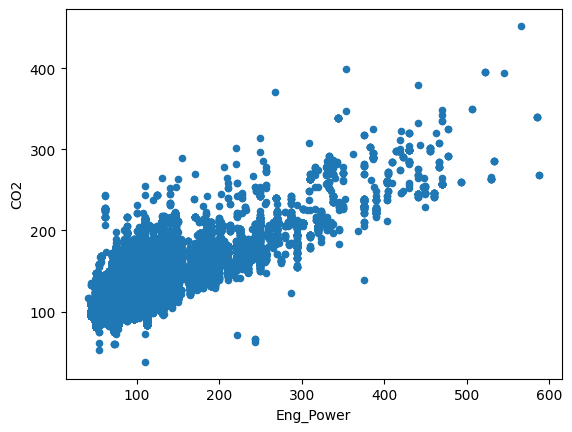

In [23]:
# The Engine Power is NaN for about 15% of the observations.
# But it is a relevant variable!

df.plot.scatter('Eng_Power', 'CO2')


In [24]:

# We have to investigate if the missing values are randomly missing or 
# if they are missing selectively on certain types of cars/CO2 emissions.

# Therefore we make a dummy (=1 if Eng_Power is NaN, =0 otherwise)

df["Eng_Power_missing"] = df["Eng_Power"].apply(lambda x: 0 if x>0 else 1)
df["Eng_Power_missing"].value_counts()



Eng_Power_missing
0    126974
1     21998
Name: count, dtype: int64

In [25]:
pd.crosstab(df["Fuel_Mode"], df["Eng_Power_missing"])

Eng_Power_missing,0,1
Fuel_Mode,,
B,1747,0
F,70,0
H,5274,944
M,119883,21054


In [26]:
pd.crosstab(df["Fuel_Type"], df["Eng_Power_missing"])

Eng_Power_missing,0,1
Fuel_Type,,
diesel,43219,6179
e85,70,0
lpg,1788,0
ng,488,0
ng-biomethane,196,0
petrol,81213,15819


In [ ]:
# In order to find if missing data is random or selective on CO2

df["CO2"].describe()



In [27]:
# We make two variables, where CO2 is set to ZERO if Eng_Power is/is not missing

df["Prov_CO2_Eng_given"]  = df["CO2"] * (1 - df["Eng_Power_missing"])
df["Prov_CO2_Eng_misses"] = df["CO2"] * df["Eng_Power_missing"]

# If CO2 is ZERO, we set it NaN, so that in the histograms it does not appear.

df["CO2_Eng_given"]  = df["Prov_CO2_Eng_given"].apply(lambda x: x if x>0 else np.nan)
df["CO2_Eng_misses"] = df["Prov_CO2_Eng_misses"].apply(lambda x: x if x>0 else np.nan)

df = df.drop(["Prov_CO2_Eng_given","Prov_CO2_Eng_misses"], axis=1)



In [28]:
df["CO2_Eng_given"].describe()

count    126974.000000
mean        125.329548
std          24.595647
min          38.000000
25%         110.000000
50%         120.000000
75%         136.000000
max         452.000000
Name: CO2_Eng_given, dtype: float64

In [29]:
df["CO2_Eng_misses"].describe()

count    21998.000000
mean       131.152832
std         27.872808
min         75.000000
25%        113.000000
50%        125.000000
75%        144.000000
max        367.000000
Name: CO2_Eng_misses, dtype: float64

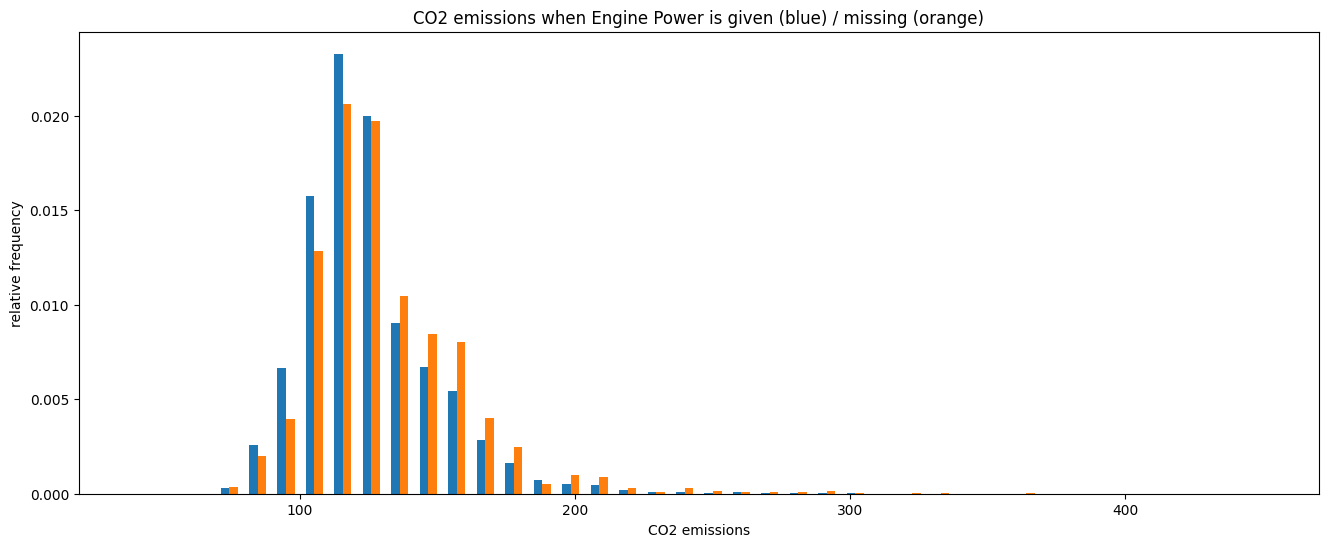

In [30]:
fig = plt.figure(figsize=(16,6))
plt.title('CO2 emissions when Engine Power is given (blue) / missing (orange)')
plt.ylabel('relative frequency')
plt.xlabel('CO2 emissions')
plt.hist((df["CO2_Eng_given"],df["CO2_Eng_misses"]) , bins =40, rwidth=0.6, density=True);

# It can be clearly seen that the missing of Eng_Power is selective on CO2 emissions.
# Maybe the manufacturers intend to cover up the link between them, because
# the cars where Engine Power is not mentionend tend to have higher CO2 emissions.
# This is not random, since the sample size is very large (>20.000)

# It is doubtful if incorporating Eng_Power is correct or will bias the estimators.
# We will compare both results, with or without this variable.

# However, the NaN's for Eng_Power have to remain in the data set !!!


In [31]:
# We drop row where Axle Width and Wheel Base are NaN, since these are just about 100 observations each.
# (if there is time left, we could try to fill Axle Width up via Type.No...)

df = df.dropna(axis=0, how="any", subset=["Axle_Width","Wheel_Base"])
df.isna().sum()

CO2                             0
Mass                            0
Axle_Width                      0
Wheel_Base                      0
Eng_Capacity                    7
Eng_Power                   21997
Manufacturer                    0
Country                         0
Vehicle_Category                0
Fuel_Type                       0
Fuel_Mode                       0
Four_Wheel_Drive                0
Fuel_Mode_B                     0
Fuel_Mode_F                     0
Fuel_Mode_H                     0
Fuel_Mode_M                     0
Fuel_Type_diesel                0
Fuel_Type_e85                   0
Fuel_Type_lpg                   0
Fuel_Type_ng                    0
Fuel_Type_ng-biomethane         0
Fuel_Type_petrol                0
ERT                             0
Eng_Power_missing               0
CO2_Eng_given               21997
CO2_Eng_misses             126707
dtype: int64

In [ ]:
df.info()

In [35]:
#Modeling

#Multiple linear regression
var_num = df.select_dtypes(include = ['int', 'float'])
var_num.info()


<class 'pandas.core.frame.DataFrame'>
Index: 148704 entries, 7701815 to 951196
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CO2                      148704 non-null  float64
 1   Mass                     148704 non-null  float64
 2   Axle_Width               148704 non-null  float64
 3   Wheel_Base               148704 non-null  float64
 4   Eng_Capacity             148697 non-null  float64
 5   Eng_Power                126707 non-null  float64
 6   Four_Wheel_Drive         148704 non-null  int64  
 7   Fuel_Mode_B              148704 non-null  int32  
 8   Fuel_Mode_F              148704 non-null  int32  
 9   Fuel_Mode_H              148704 non-null  int32  
 10  Fuel_Mode_M              148704 non-null  int32  
 11  Fuel_Type_diesel         148704 non-null  int32  
 12  Fuel_Type_e85            148704 non-null  int32  
 13  Fuel_Type_lpg            148704 non-null  int32  
 14  Fue

In [36]:
var_num = var_num.drop(['CO2',"CO2_Eng_misses","Eng_Power_missing"], axis =1)
var_num=var_num.dropna()
var_num.info()


<class 'pandas.core.frame.DataFrame'>
Index: 126705 entries, 7701815 to 4900907
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Mass                     126705 non-null  float64
 1   Axle_Width               126705 non-null  float64
 2   Wheel_Base               126705 non-null  float64
 3   Eng_Capacity             126705 non-null  float64
 4   Eng_Power                126705 non-null  float64
 5   Four_Wheel_Drive         126705 non-null  int64  
 6   Fuel_Mode_B              126705 non-null  int32  
 7   Fuel_Mode_F              126705 non-null  int32  
 8   Fuel_Mode_H              126705 non-null  int32  
 9   Fuel_Mode_M              126705 non-null  int32  
 10  Fuel_Type_diesel         126705 non-null  int32  
 11  Fuel_Type_e85            126705 non-null  int32  
 12  Fuel_Type_lpg            126705 non-null  int32  
 13  Fuel_Type_ng             126705 non-null  int32  
 14  Fu

In [37]:

target = var_num['CO2_Eng_given']
data=var_num.drop("CO2_Eng_given", axis=1)

In [ ]:
data.info()

In [55]:
#Multiple linear regression

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=200)

lr = LinearRegression() #Instanciate a regression slr of the class LinearRegression.
lr.fit(X_train, y_train) # Fit the model

print(lr.intercept_) # display intercept (y value at the origin)
print(lr.coef_) #display coefficient (slope)


108.49543420615655
[ 7.18061985e-02 -4.36106154e-02 -1.84514391e-02  1.25632985e-02
  8.73364497e-02  3.29106476e+00  5.83965771e+00  2.37380979e+01
 -3.53193813e+01  5.74162574e+00 -1.43352403e+01  2.37380979e+01
  1.36530916e+01 -2.17805428e+01 -1.10801878e+01  9.80478141e+00
 -5.02437165e+00]


In [56]:
lr_coef=lr.coef_
coef=pd.DataFrame(lr_coef,index=data.columns)
coef.T.head()

,Mass,Axle_Width,Wheel_Base,Eng_Capacity,Eng_Power,Four_Wheel_Drive,Fuel_Mode_B,Fuel_Mode_F,Fuel_Mode_H,Fuel_Mode_M,Fuel_Type_diesel,Fuel_Type_e85,Fuel_Type_lpg,Fuel_Type_ng,Fuel_Type_ng-biomethane,Fuel_Type_petrol,ERT
0,0.071806,-0.043611,-0.018451,0.012563,0.087336,3.291065,5.839658,23.738098,-35.319381,5.741626,-14.33524,23.738098,13.653092,-21.780543,-11.080188,9.804781,-5.024372


In [57]:
print("Coefficient of determination of the model :", lr.score(X_train, y_train)) #PRint the R2 score
print("Coefficient of determination with cross-validation :", cross_val_score(lr,X_train,y_train).mean()) # Print the cross-validation score


Coefficient of determination of the model : 0.7317982693747277
Coefficient of determination with cross-validation : 0.7316091089524839


In [58]:
print("Score :", lr.score(X_test, y_test)) # Score on the test data
pred_test = lr.predict(X_test) #model predictions for X_test



Score : 0.7223683362747917


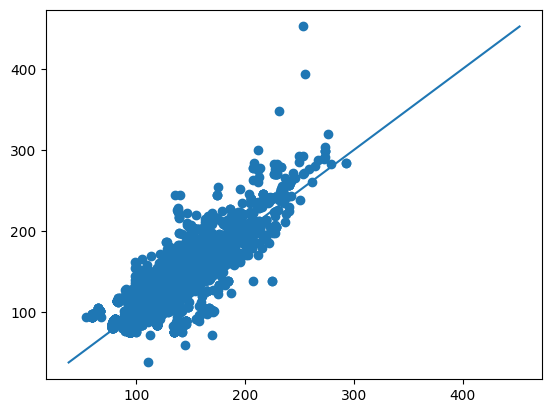

In [42]:
plt.scatter(pred_test, y_test) #scatterplot between pred_test and y_test,
plt.plot((y_test.min(),y_test.max()), (y_test.min(),y_test.max())) #adding the line of equation 𝑦=𝑥


In [ ]:
pred_train = lr.predict(X_train) #Calculation of the adjusted values (pred_train) 
residues = pred_train - y_train # Calculation of the residues of the model


#A first simple graph representing the residues as a function of the target variable gives an estimate of the homoscedasticity of the residues, 
# which should be randomly scattered in the graph around the line 𝑦=0, with no apparent structure.
plt.scatter(y_train, residues, color = '#980a10', s=15) # scatterplot between the residues and the values of y_train.
plt.plot((y_train.min(),y_train.max()), (0,0), lw=3, color = '#0a5798')


In [ ]:

# For normality, we can plot a QQ plot
residues_norm = (residues-residues.mean())/residues.std() # Center and reduce the residues in a vector called residues_norm

stats.probplot(residues_norm, plot=plt) # Create a Quantile-Quantile or (Q-Q plot) diagram to evaluate the relevance of adjusting a given distribution to a theoretical model (often a reduced, centered Gaussian law).

plt.show() # Display QQ plot


<Axes: >

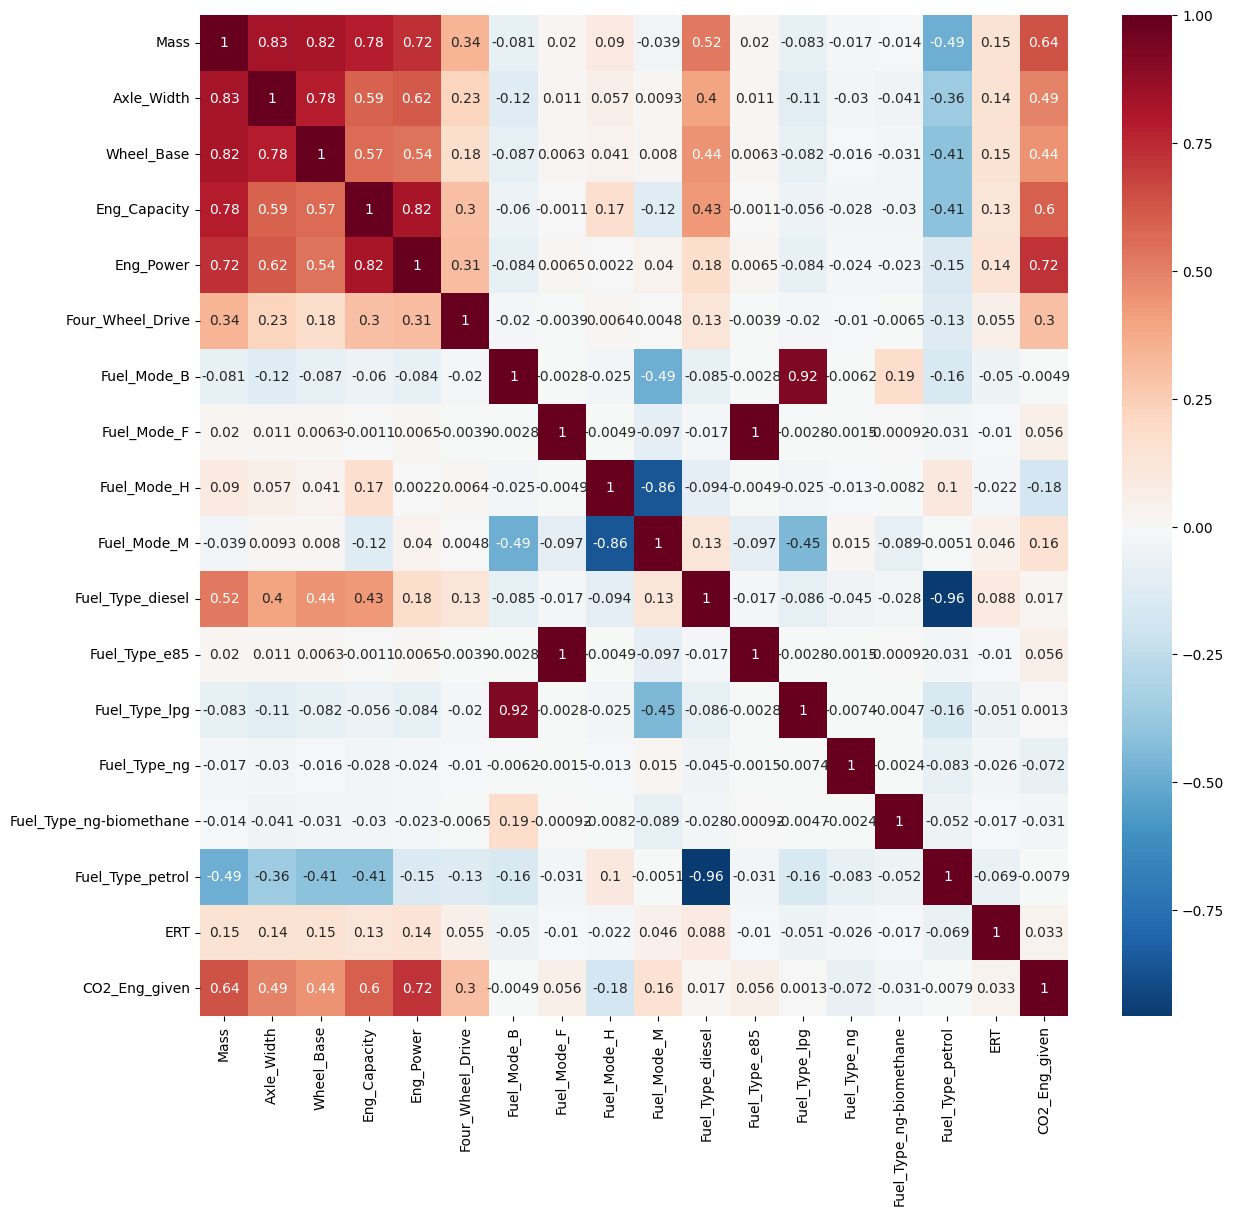

In [43]:

# Display a heatmap of the correlations between each pair of variables of df, with 0 for center and use the palette "RdBu_r"
plt.figure(figsize=(14,13))
sns.heatmap(var_num.corr(),annot=True, cmap="RdBu_r", center =0)


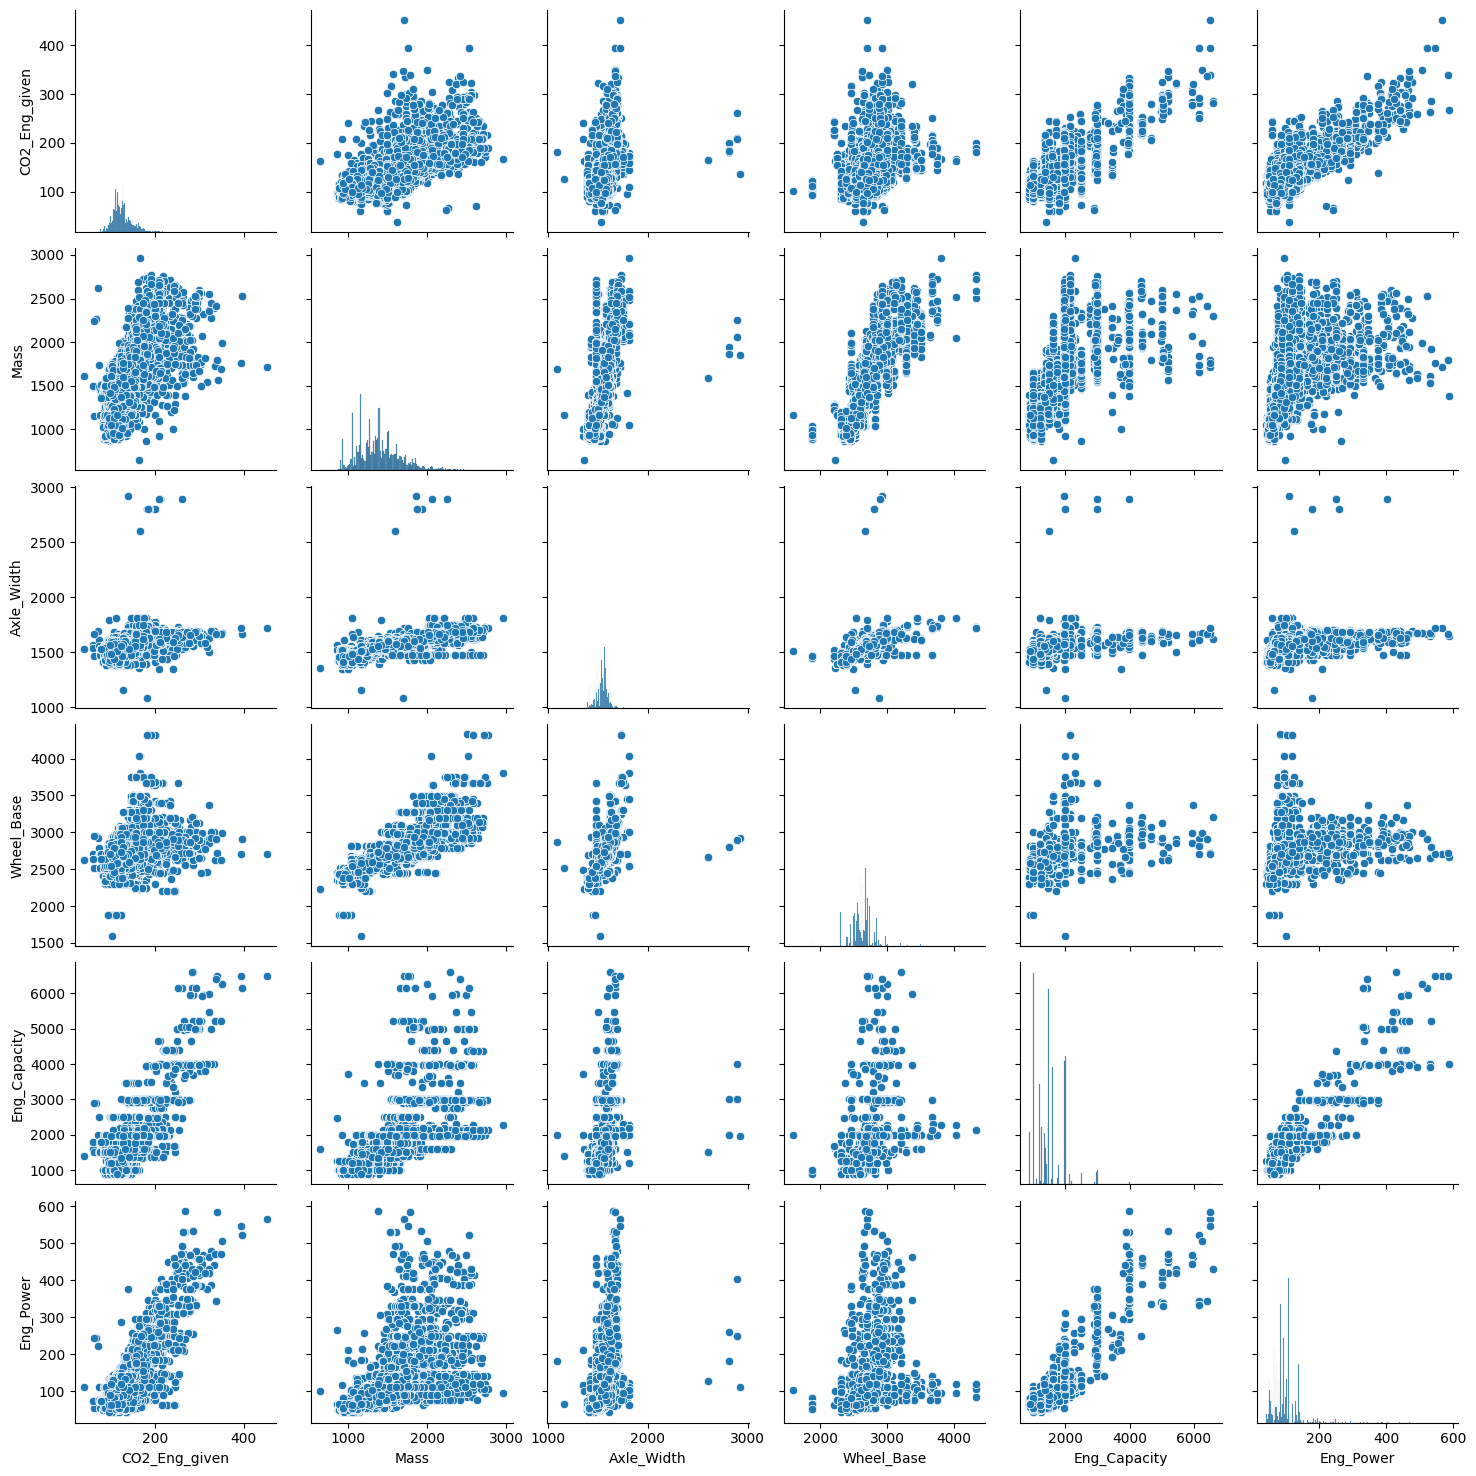

In [44]:
sns.pairplot(var_num[['CO2_Eng_given', 'Mass', 'Axle_Width', 'Wheel_Base', 'Eng_Capacity', 'Eng_Power']]) # Pairplot with specific variables and the target 'CO2_Eng_given'
#from this, does axle width and wheelp base have a linear relationship with CO2?

In [47]:
signif_features = ['Mass', 'Eng_Capacity',"Wheel_Base", 'Eng_Power'] # List with the names of specific variables
lr2 = LinearRegression() #Instanciate a regression slr of the class LinearRegression.
lr2.fit(X_train[signif_features], y_train) # train the model only with the variables of signif_features
print(lr2.score(X_train[signif_features], y_train)) # Display the score (R²) of the model on the training set used.
print(lr2.score(X_test[signif_features], y_test)) # Display the score (R²) of the model on the variables signif_features of the test sample.


0.559649237407891
0.5499521414653303


In [49]:

sk = SelectKBest(f_regression, k=3) # Create selector sk using the results of the function f_regression

sk.fit(data, target) # fit the selector with data and target dataframes

print(data.columns[sk.get_support()]) # Display the names of the columns of data selected by the selector (most correlated with target)

sk_train=sk.transform(X_train)
sk_test=sk.transform(X_test)

sklr = LinearRegression() # a linear regression model from sk_train and y_train.
sklr.fit(sk_train, y_train) 

print(sklr.score(sk_train, y_train)) # Display the score of the model on the training set as well as on sk_test.
print(sklr.score(sk_test, y_test))


Index(['Mass', 'Eng_Capacity', 'Eng_Power'], dtype='object')
0.5499717981764416
0.5412814464980931


In [50]:
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing

lr = LinearRegression() # instantiate lr linear regression model
sfm = SelectFromModel(lr) #create selector sfm

scaler = preprocessing.StandardScaler().fit(X_train) #standardization (mandatory when using the coefficients of a regression model, if the variables are not of the same order.

X_train_scaled = scaler.transform(X_train) # standard X_train table
X_test_scaled = scaler.transform(X_test) # standard X_test table

sfm_train = sfm.fit_transform(X_train_scaled, y_train) #save columns of X_train_scaled selected by sfm
sfm_test = sfm.transform(X_test_scaled) #save columns of X_ttest_scaled selected by sfm

print(data.columns[sfm.get_support()]) # Display the names of the columns selected by sfm

sfmlr = LinearRegression() # Create a model from the selected vaiables
sfmlr.fit(sfm_train, y_train)

print(sfmlr.score(sfm_train, y_train)) # Display model score on training set
print(sfmlr.score(sfm_test, y_test))  # Display model score on test set

Index(['Fuel_Mode_B', 'Fuel_Mode_H', 'Fuel_Mode_M', 'Fuel_Type_diesel',
       'Fuel_Type_petrol'],
      dtype='object')
0.04092305166238197
0.0458952948453909


In [ ]:
var_num = df.select_dtypes(include = ['int', 'float'])
var_num.info()

var_num = var_num.drop(['CO2',"CO2_Eng_misses","Eng_Power_missing"], axis =1)
var_num.info()

var_num=var_num.dropna()
var_num.info()


In [51]:
var_num_pre = pd.DataFrame(preprocessing.StandardScaler().fit_transform(var_num)) # normalize data
target_pre = var_num['CO2_Eng_given']
data_pre=var_num.drop("CO2_Eng_given", axis=1)

X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(data_pre, target_pre, test_size=0.2, random_state = 789) #separate data


In [52]:
#Ridge regression
from sklearn.linear_model import RidgeCV

ridge_reg = RidgeCV(alphas= (0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 50, 100)) # instantiate model with a list of a parameters
ridge_reg.fit(X_train_pre, y_train_pre) #fit the model

print( "alpha selected by c-v :" ,ridge_reg.alpha_) # Display the 𝛼 retained by the model
print("score train :", ridge_reg.score(X_train_pre, y_train_pre)) # Display score (R²) of the model on the training set
print("score test :", ridge_reg.score(X_test_pre, y_test_pre)) #  Display score (R²) of the model on the test set


ridge_pred_train = ridge_reg.predict(X_train_pre) # Store the fitted values of the model
ridge_pred_test = ridge_reg.predict(X_test_pre) # Store the model predictions


print("mse train:", mean_squared_error(ridge_pred_train, y_train_pre)) # Display mean square error for fitted values
print("mse test:", mean_squared_error(ridge_pred_test, y_test_pre)) # Display mean square error of prediction 


alpha selected by c-v : 0.3
score train : 0.7303893962333656
score test : 0.7281158185189471
mse train: 162.55201999322858
mse test: 157.57939302025864


In [59]:
rigde_coef=ridge_reg.coef_
print(rigde_coef)

coef_ridge=pd.DataFrame(rigde_coef,index=data_pre.columns)
coef_ridge.T.head()


[ 7.12732812e-02 -4.25930204e-02 -1.86593391e-02  1.23316983e-02
  9.11340253e-02  3.73802207e+00  5.89429464e+00  2.36512912e+01
 -3.53321383e+01  5.78655249e+00 -1.41821719e+01  2.36512912e+01
  1.38991837e+01 -2.16711591e+01 -1.14529159e+01  9.75577198e+00
 -5.10854213e+00]


,Mass,Axle_Width,Wheel_Base,Eng_Capacity,Eng_Power,Four_Wheel_Drive,Fuel_Mode_B,Fuel_Mode_F,Fuel_Mode_H,Fuel_Mode_M,Fuel_Type_diesel,Fuel_Type_e85,Fuel_Type_lpg,Fuel_Type_ng,Fuel_Type_ng-biomethane,Fuel_Type_petrol,ERT
0,0.071273,-0.042593,-0.018659,0.012332,0.091134,3.738022,5.894295,23.651291,-35.332138,5.786552,-14.182172,23.651291,13.899184,-21.671159,-11.452916,9.755772,-5.108542


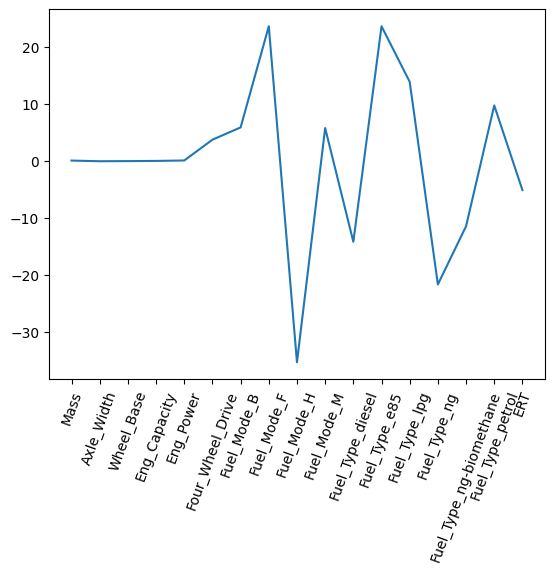

In [60]:

plt.plot(range(len(data_pre.columns)), rigde_coef) #Display a graph representing the estimated coefficient value for each variable of data.
plt.xticks(range(len(data_pre.columns)), data_pre.columns.values, rotation=70)
plt.show()
# If there is a significant error difference between the training sample and the test sample,  probably the model overfits the training set.


In [61]:
from sklearn.linear_model import lasso_path

my_alphas = (0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0) # Create list of alphas
alpha_path, coefs_lasso, _ = lasso_path(X_train_pre, y_train_pre, alphas=my_alphas) # matrix of coefficients associated with the data and the chosen alphas
coefs_lasso.shape # Check dimensions of matrix


c:\Users\Pinelopi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10358000.786208004, tolerance: 165166.1675
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Pinelopi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9014722.804689266, tolerance: 165166.1675
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Pinelopi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9473879.866411332, tolerance: 165166.1675
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Pin

(17, 10)

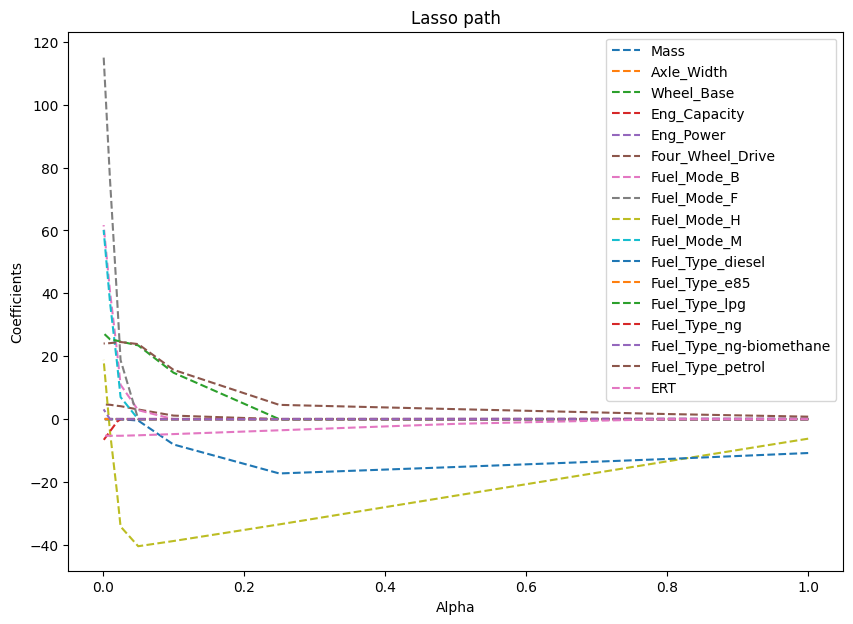

In [67]:
# For each explanatory variable, plot the curve of the values of the corresponding estimated coefficient as a function of the values taken by 𝛼 in alpha_path.
import matplotlib.cm as cm
plt.figure(figsize=(10,7))

for i in range(coefs_lasso.shape[0]):
    plt.plot(alpha_path, coefs_lasso[i,:], '--')

plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso path')
plt.legend(data_pre.columns)
plt.show()


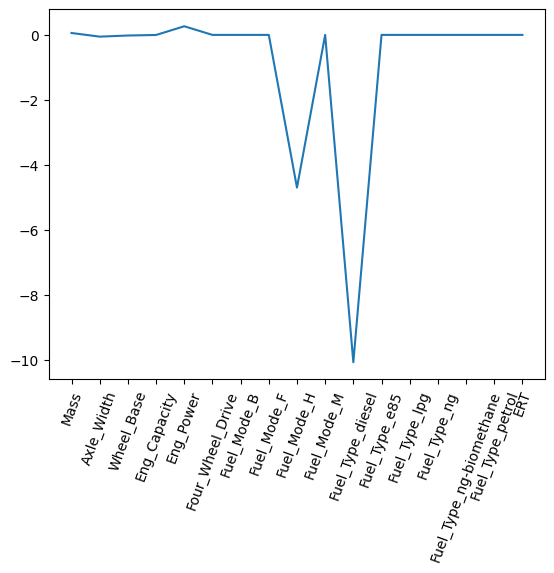

In [63]:
from sklearn.linear_model import Lasso

lasso_r = Lasso(alpha=1) # Instantiate Lasso model
lasso_r.fit(X_train_pre, y_train_pre) # Fit model on training data
lasso_coef=lasso_r.coef_ #Displays coefficients

plt.plot(range(len(data_pre.columns)), lasso_coef) #Display a graph representing the estimated coefficient value for each variable of data.
plt.xticks(range(len(data_pre.columns)), data_pre.columns.values, rotation=70)
plt.show()


In [65]:
print("score train :", lasso_r.score(X_train_pre, y_train_pre)) # Display score (R²) of the model on the training set
print("score test :", lasso_r.score(X_test_pre, y_test_pre)) #  Display score (R²) of the model on the test set


lasso_r_pred_train = lasso_r.predict(X_train_pre) # Store the fitted values of the model
lasso_r_pred_test = lasso_r.predict(X_test_pre) # Store the model predictions


print("mse train:", mean_squared_error(lasso_r_pred_train, y_train_pre)) # Display mean square error for fitted values
print("mse test:", mean_squared_error(lasso_r_pred_test, y_test_pre)) # Display mean square error of prediction 


score train : 0.6333644224061893
score test : 0.6280225359913512
mse train: 221.04973953785378
mse test: 215.59173717424534


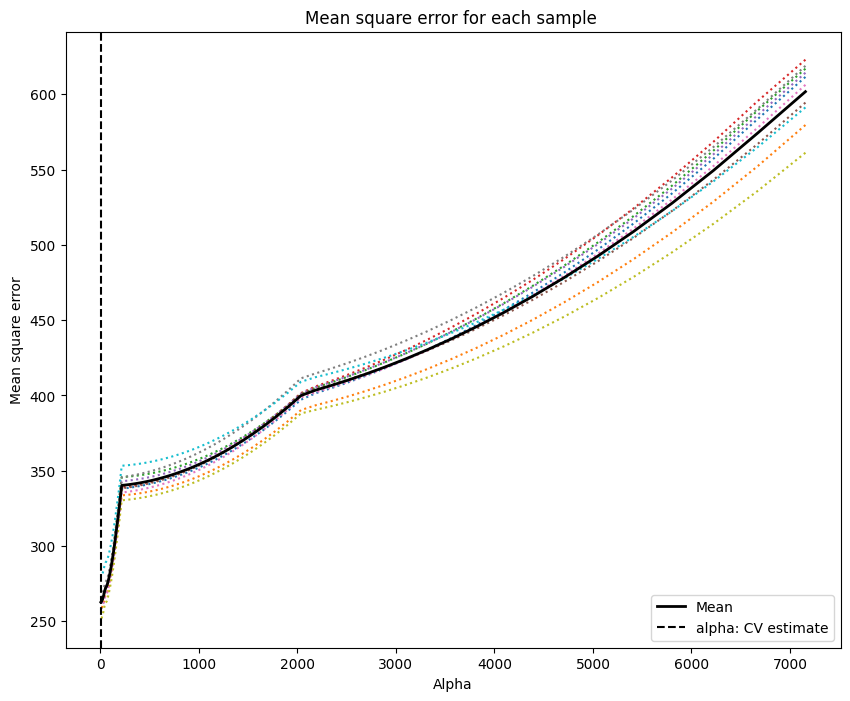

score train : 0.564645096053978
score test : 0.5559503491335491


In [77]:
from sklearn.linear_model import LassoCV

model_lasso = LassoCV(cv=10).fit(X_train_pre, y_train_pre) # Create and fit model on the training set

alphas = model_lasso.alphas_ # Get the different 𝛼 tested by the model and assign them to the variable alphas.

plt.figure(figsize = (10,8))

plt.plot(alphas, model_lasso.mse_path_, ':') # Curve representing MSE errors as a function of the values of a for each sample of cross-validation

plt.plot(alphas, model_lasso.mse_path_.mean(axis=1), 'k', # Curve representing the average of the MSE scores on all samples, based on the values of 𝛼 tested.
         label='Mean', linewidth=2)

plt.axvline(model_lasso.alpha_, linestyle='--', color='k', #Vertical line on the value of 𝛼 selected by the model.
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('Alpha')
plt.ylabel('Mean square error')
plt.title('Mean square error for each sample ')
plt.show()

print("score train :", model_lasso.score(X_train_pre, y_train_pre)) # Display score (R²) of the model on the training set
print("score test :", model_lasso.score(X_test_pre, y_test_pre)) #  Display score (R²) of the model on the test set


In [71]:


knn = neighbors.KNeighborsClassifier(n_neighbors=7, metric='minkowski') # Creation of the classifier
knn.fit(X_train, y_train) # construction of the model on the training data

# Evaluation of the model
y_pred_knn= knn.predict(X_test) # Apply the model

pd.crosstab(y_test, y_pred_knn, rownames=['Real'], colnames=['Predicted']) # Display confusion matrix

#Creation of the new classifier and training of the model
knn_m = neighbors.KNeighborsClassifier(n_neighbors=5, metric='manhattan')
knn_m.fit(X_train, y_train)

#Score of the model using the Minkowski distance
score_minkowski = knn.score(X_test, y_test)

#Score of the model using the Manhattan distance
score_manhattan = knn_m.score(X_test, y_test)

score_minkowski, score_manhattan



(0.6760585612248925, 0.6772029517382897)

In [ ]:
#this does not work and I dont think it is necessary anyways
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier

pca = PCA() #  Create a new instance of PCA without specifying the number of components.
pca.fit_transform(data) #fit


In [ ]:
#this does not work 
# Plot the explained variance ratio as a function of the Principal Component index.
plt.figure()
plt.xlim(0.100)
plt.plot(pca.explained_variance_ratio_); #The explained_variance_ratio_ attribute of the PCA class contains a numpy vector of the size of the number of components of the PCA. The i-th element of this vector contains the explained variance ratio by the ith principal component. 

#Plot the cumulative sum of the explained variance in a new graph.
plt.figure()
plt.xlim(0.100)
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.axhline(y = 0.9, color = 'r', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum()); # This vector can be transformed to have the cumulative sum of the explained variance using the cumsum() method. 




In [ ]:
#Using the explained_variance_ratio_ attribute, display a histogram of the explained variance ratio by each of the 2 axes constructed by the PCA.
variance_expliquee = pca.explained_variance_ratio_

plt.bar(range(len(variance_expliquee)), variance_expliquee)
plt.xticks([0, 1], ['Axe 1', 'Axe 2'])
plt.xlabel('Main component')
plt.ylabel('Explained variance ratio')
plt.title('Explained variance ratio by Principal Component')
plt.show()


In [ ]:

# To display a table with the correlation values of each variable with the (2) axis:
comp=pca.components_
comp.shape

In [ ]:

df2=pd.DataFrame(comp, columns=data.columns, index=['Axe 1', 'Axe 2'])


In [ ]:

#For correlation circle:
charges_factorielles = pca.components_

# Create the correlation circle
def draw_correlation_circle(df_charges_factorielles, pca, arrow_length=0.1, label_rotation=0):
    fig, ax = plt.subplots(figsize=(8, 8))
    for i, var in enumerate(df_charges_factorielles.columns):
        x = df_charges_factorielles.loc['Axe 1', var]
        y = df_charges_factorielles.loc['Axe 2', var]
        ax.arrow(0, 0, x, y, head_width=arrow_length, head_length=arrow_length, fc='gray', ec='gray')
        ax.text(x*1.15, y*1.15, var, ha='center', va='center', rotation=label_rotation, fontsize=9)
    circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='black')
    ax.add_artist(circle)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('Axe 1 (PC1)')
    ax.set_ylabel('Axe 2 (PC2)')
    ax.set_title('Correlation circle')
    plt.grid()
    plt.show()

# Call the function to plot the correlation circle
draw_correlation_circle(df_charges_factorielles, pca)


In [ ]:

#Display dataset reduced to 2 dimensions:
data_2D = pca.fit_transform(data)
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(data_2D[:, 0], data_2D[:, 1])

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
plt.annotate(WGI.iloc[105]['Country/Territory'], (data_2D[105, 0], data_2D[105, 1] - 0.15), textcoords="offset points", xytext=(0, 10),
                ha='center', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

plt.annotate(WGI.iloc[120]['Country/Territory'], (data_2D[120, 0], data_2D[120, 1] - 0.15), textcoords="offset points", xytext=(0, 10),
                ha='center', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

ax.set_title("Projected data on the 2 PCA axes")
plt.show();



In [ ]:

#Display the explained variance for each component using PCA's explained_variance_ attribute.
print("The explained variance ratio is", pca.explained_variance_) # Calculate and display the explained variance ratio.

#Plot the explained variance according to the number of components.
plt.figure(figsize=(10, 10))
plt.plot(range(0, 31), pca.explained_variance_) #this can change, maybe use this: len(pca.explained_variance_)
plt.xlabel('Factor number')
plt.ylabel('Eigenvalues'); 
